In [2]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
from corner import corner


In [3]:
import surp
import vice

from surp.gce_math import Z_to_MH, MH_to_Z

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
vice.yields.ccsne.settings["c"] = 0


In [5]:
class LinearModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        m, b, σ = theta
        return m * x + b
    
    def log_prior(self, theta):
        m, b, sigma = theta
        p = 0
        p += np.log(normal(m, 0, 1e-3))
        p += np.log(normal(b, 0, 1e-3))
        p += np.log(log_normal(sigma, 1e-8, 0.5))

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-3, 1e-3, 1e-8]

In [6]:
class LogLinearModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        z = MH_to_Z(x)
        m, b, σ = theta
        return m * z + b
    
    def log_prior(self, theta):
        m, b, sigma = theta
        p = 0
        p += np.log(normal(m, 0, 1e-2))
        p += np.log(normal(b, 0, 3e-3))
        p += np.log(log_normal(sigma, 1e-8, 0.5))

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-2, 3e-3, 1e-8]

In [7]:
def linear_model(x, theta):
    """Linear model function y = mx + b."""
    m, b, sigma = theta
    return m * x + b

In [8]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [9]:
def log_likelihood(theta, x, y, model):
    pred = model(x, theta)
    sigma2 = theta[-1]
    return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_probability(theta, x, y, model):
    p = model.log_prior(theta)
    l = log_likelihood(theta, x, y, model) 
    
    lp = l + p
    return np.where(np.isfinite(lp), lp, -np.inf)

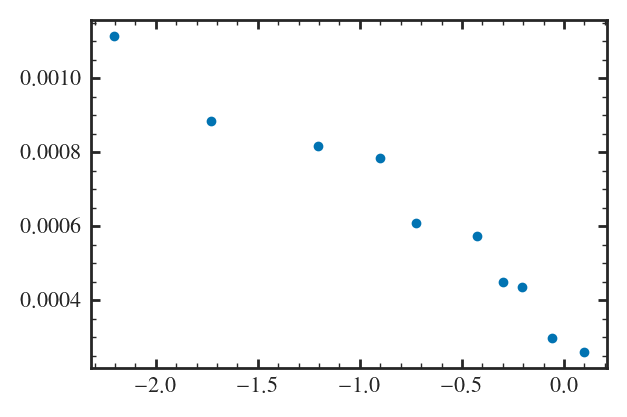

In [10]:
study = "cristallo11"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  2%|▏         | 22/1000 [00:00<00:04, 218.14it/s]/tmp/slurmtmp.27651492/ipykernel_96232/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.27651492/ipykernel_96232/2739109048.py:14: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.27651492/ipykernel_96232/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:03<00:00, 328.22it/s]


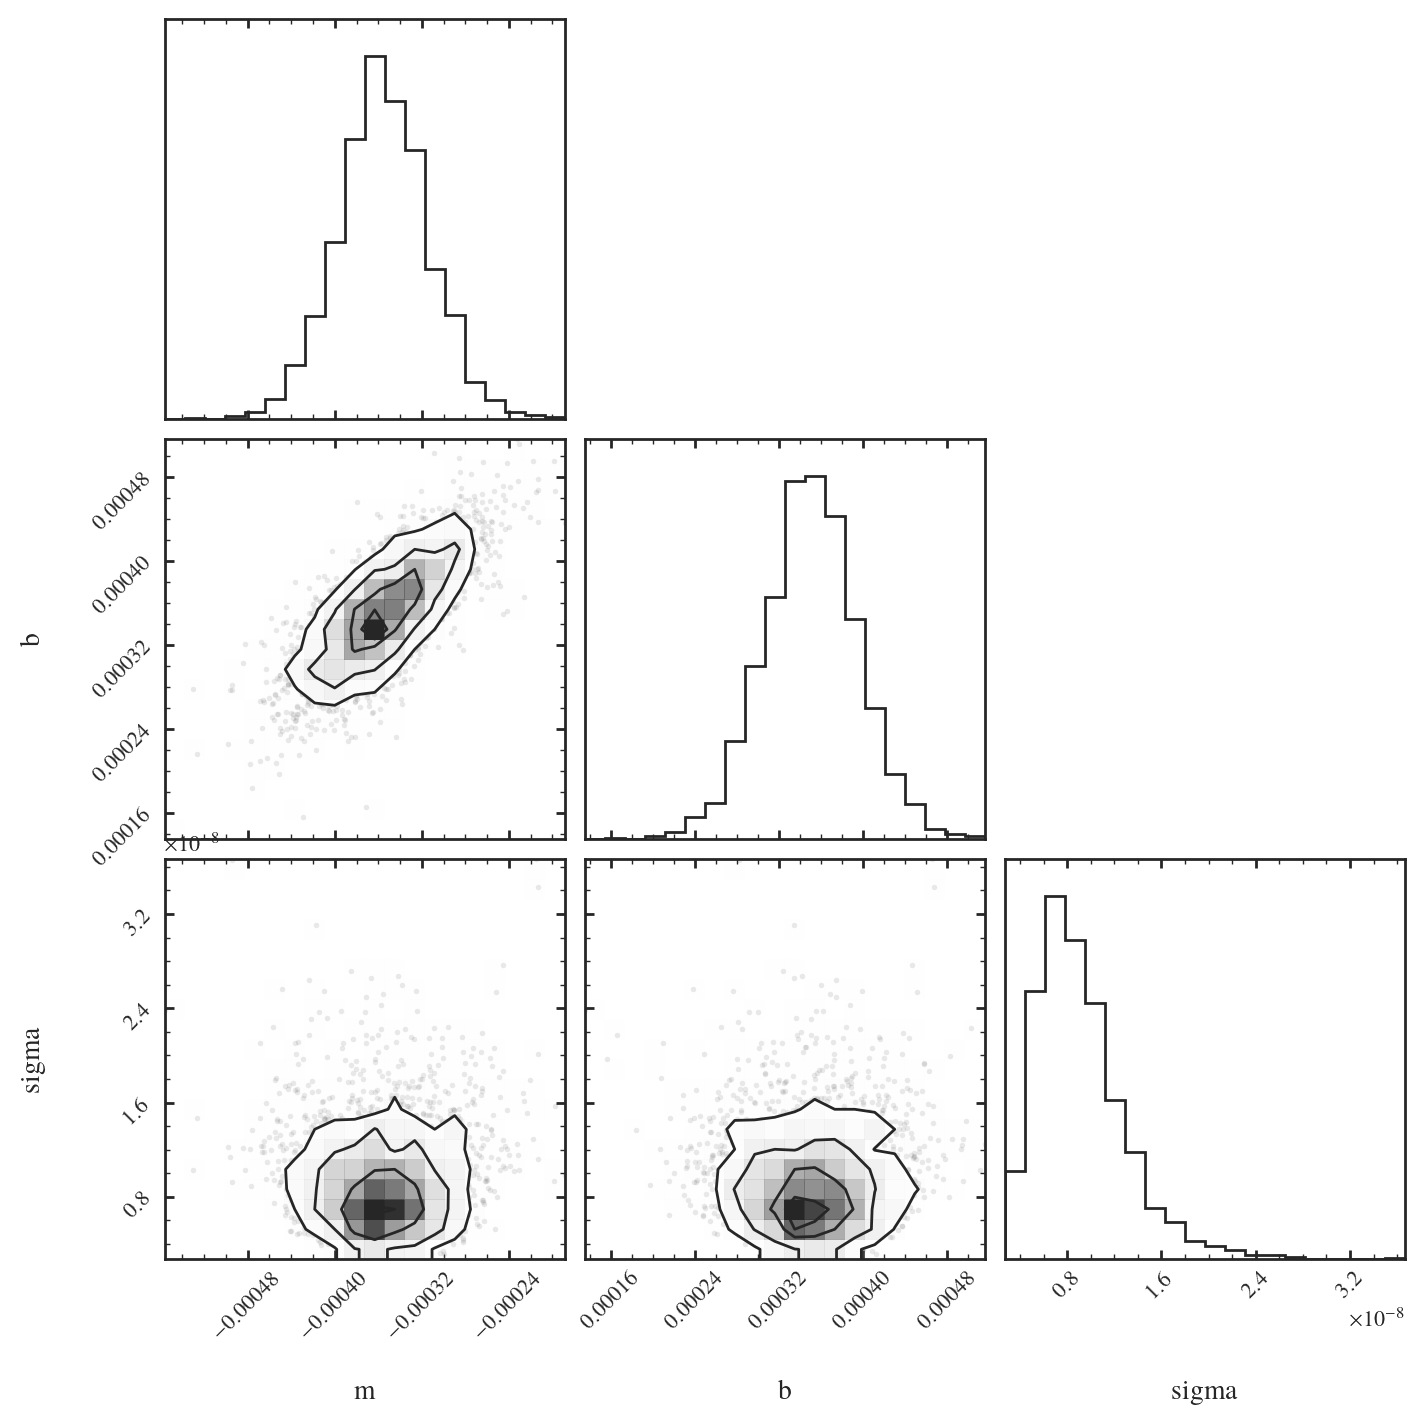

In [11]:

model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

(-0.0001, 0.001852772935557028)

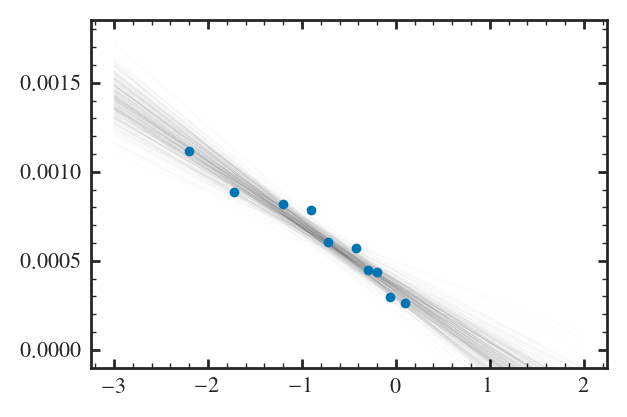

In [12]:
for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 2, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.02)
    
plt.scatter(mh1, y_c_agb1, zorder=3)
plt.ylim(-1e-4)

In [38]:
def print_range(l):
    m = np.median(l)
    pl = np.percentile(l, 20)
    ph = np.percentile(l, 80)
    print(f"{m:8.3e}  + {ph - m:8.3e} - {m - pl:8.3e}")

In [59]:
def print_stats():
    vice.yields.ccsne.settings["c"] = 0
    print("y(0)", surp.calc_y())
    print("y0")
    print_range(samples[:, 1])
    print("zeta")
    print_range(samples[:, 0] / surp.Z_SUN / np.log(10))
    print("sigma")
    print_range(samples[:, 2])

In [60]:
print_stats()

y(0) 0.000693482841654834
y0
6.248e-04  + 9.890e-05 - 1.009e-04
zeta
-1.523e-02  + 2.323e-03 - 2.322e-03
sigma
3.381e-08  + 1.134e-08 - 7.980e-09


0.00028557902325407206

# V13

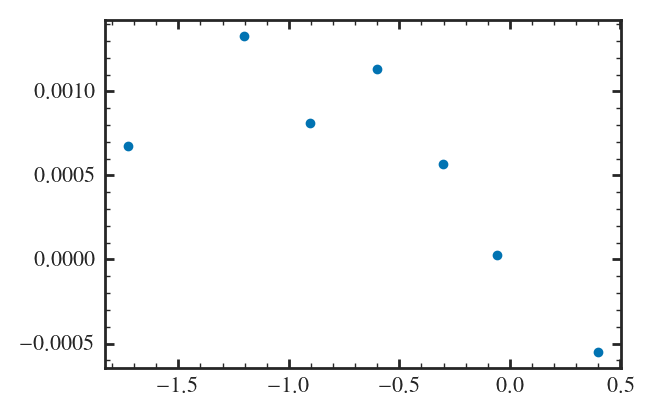

In [72]:
study = "ventura13"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  3%|▎         | 26/1000 [00:00<00:03, 253.00it/s]/tmp/slurmtmp.27651492/ipykernel_96232/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.27651492/ipykernel_96232/2739109048.py:14: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.27651492/ipykernel_96232/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:02<00:00, 353.47it/s]


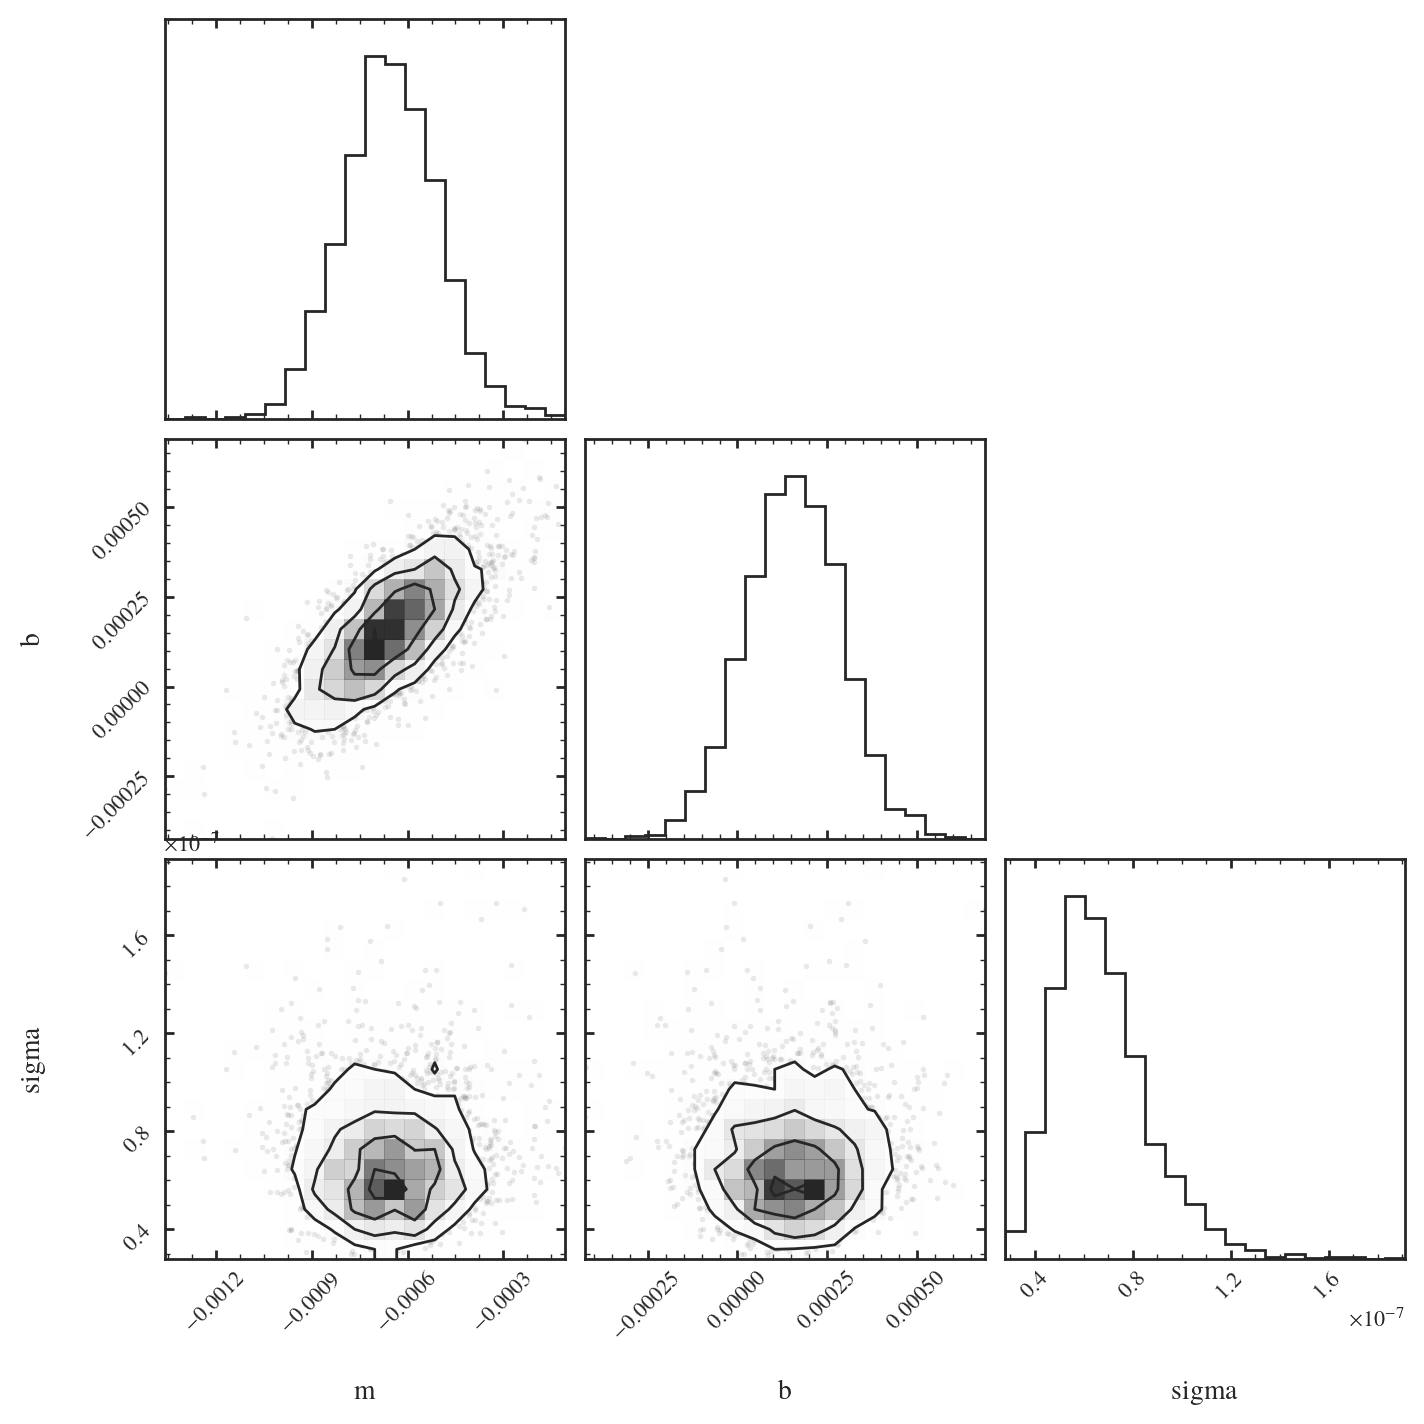

In [73]:

model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

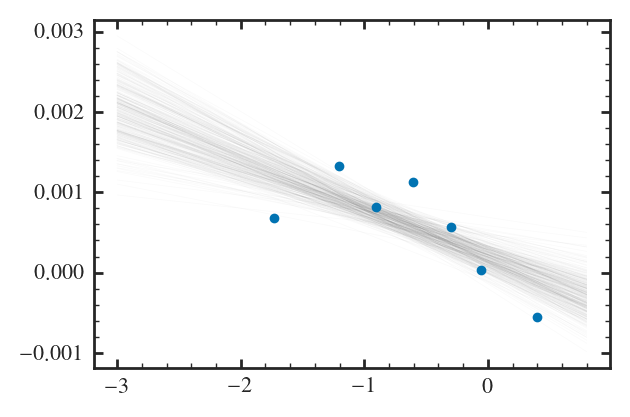

In [74]:
for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 0.8, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.02)
    
plt.scatter(mh1, y_c_agb1, zorder=3)


In [75]:
print_stats()

y(0) -1.5557976193266725e-05
y0
1.548e-04  + 1.133e-04 - 1.106e-04
zeta
-1.780e-02  + 3.468e-03 - 3.298e-03
sigma
6.496e-08  + 1.725e-08 - 1.351e-08


# K16

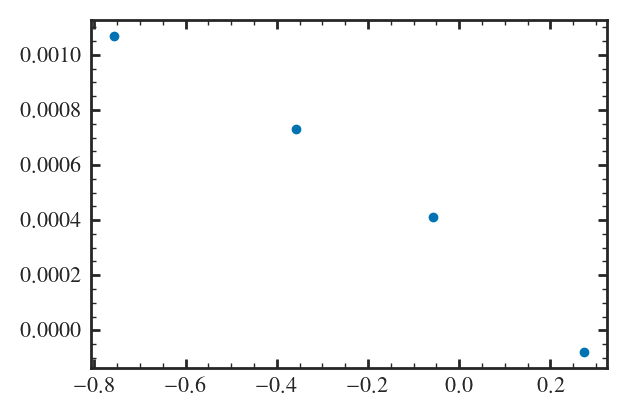

In [64]:
study = "karakas16"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  4%|▍         | 45/1000 [00:00<00:02, 445.02it/s]/tmp/slurmtmp.27651492/ipykernel_96232/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.27651492/ipykernel_96232/2739109048.py:14: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.27651492/ipykernel_96232/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:02<00:00, 348.84it/s]


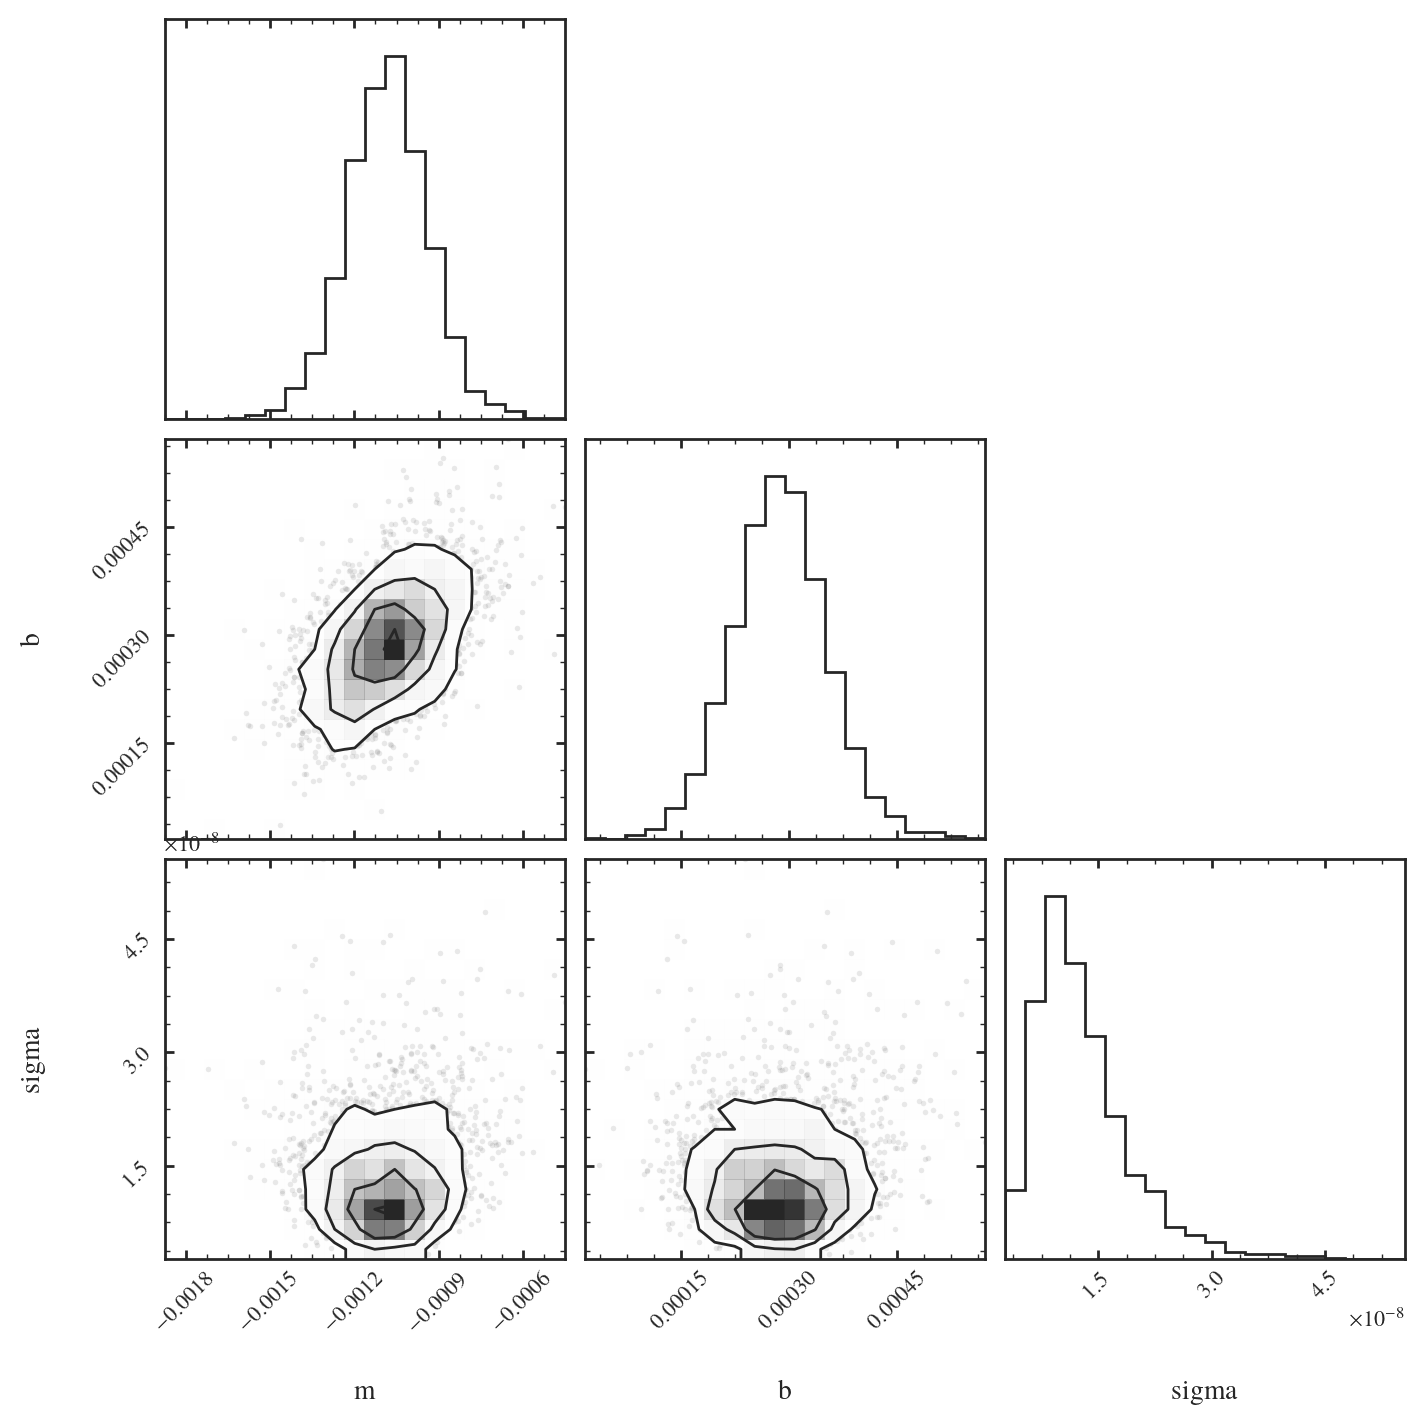

In [65]:

model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

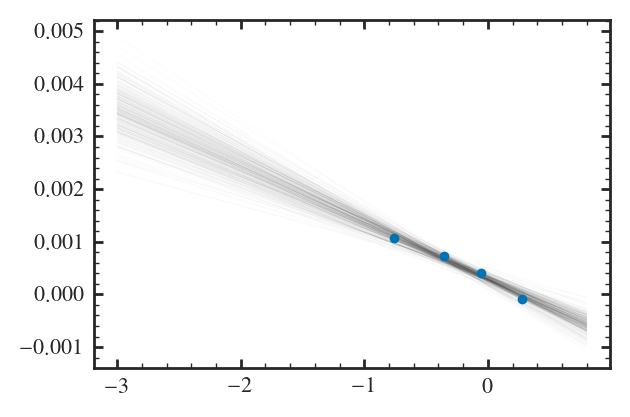

In [66]:

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 0.8, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.02)
    
plt.scatter(mh1, y_c_agb1, zorder=3)


In [67]:
print_stats()

y(0) 0.0003497671724493468
y0
2.865e-04  + 5.322e-05 - 5.287e-05
zeta
-2.941e-02  + 3.194e-03 - 3.232e-03
sigma
1.148e-08  + 5.678e-09 - 3.613e-09


# P16

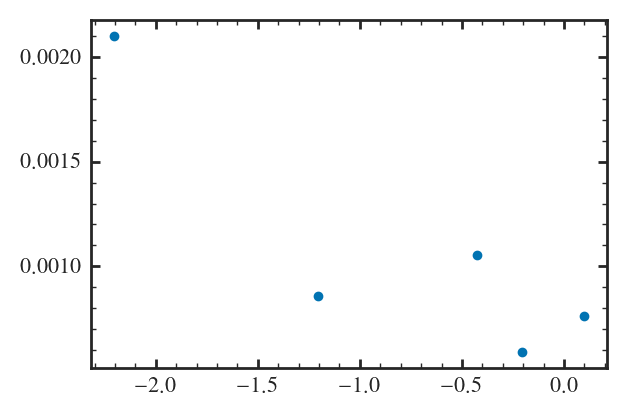

In [68]:
study = "pignatari16"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  2%|▏         | 22/1000 [00:00<00:04, 216.34it/s]/tmp/slurmtmp.27651492/ipykernel_96232/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.27651492/ipykernel_96232/2739109048.py:14: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.27651492/ipykernel_96232/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:02<00:00, 351.64it/s]


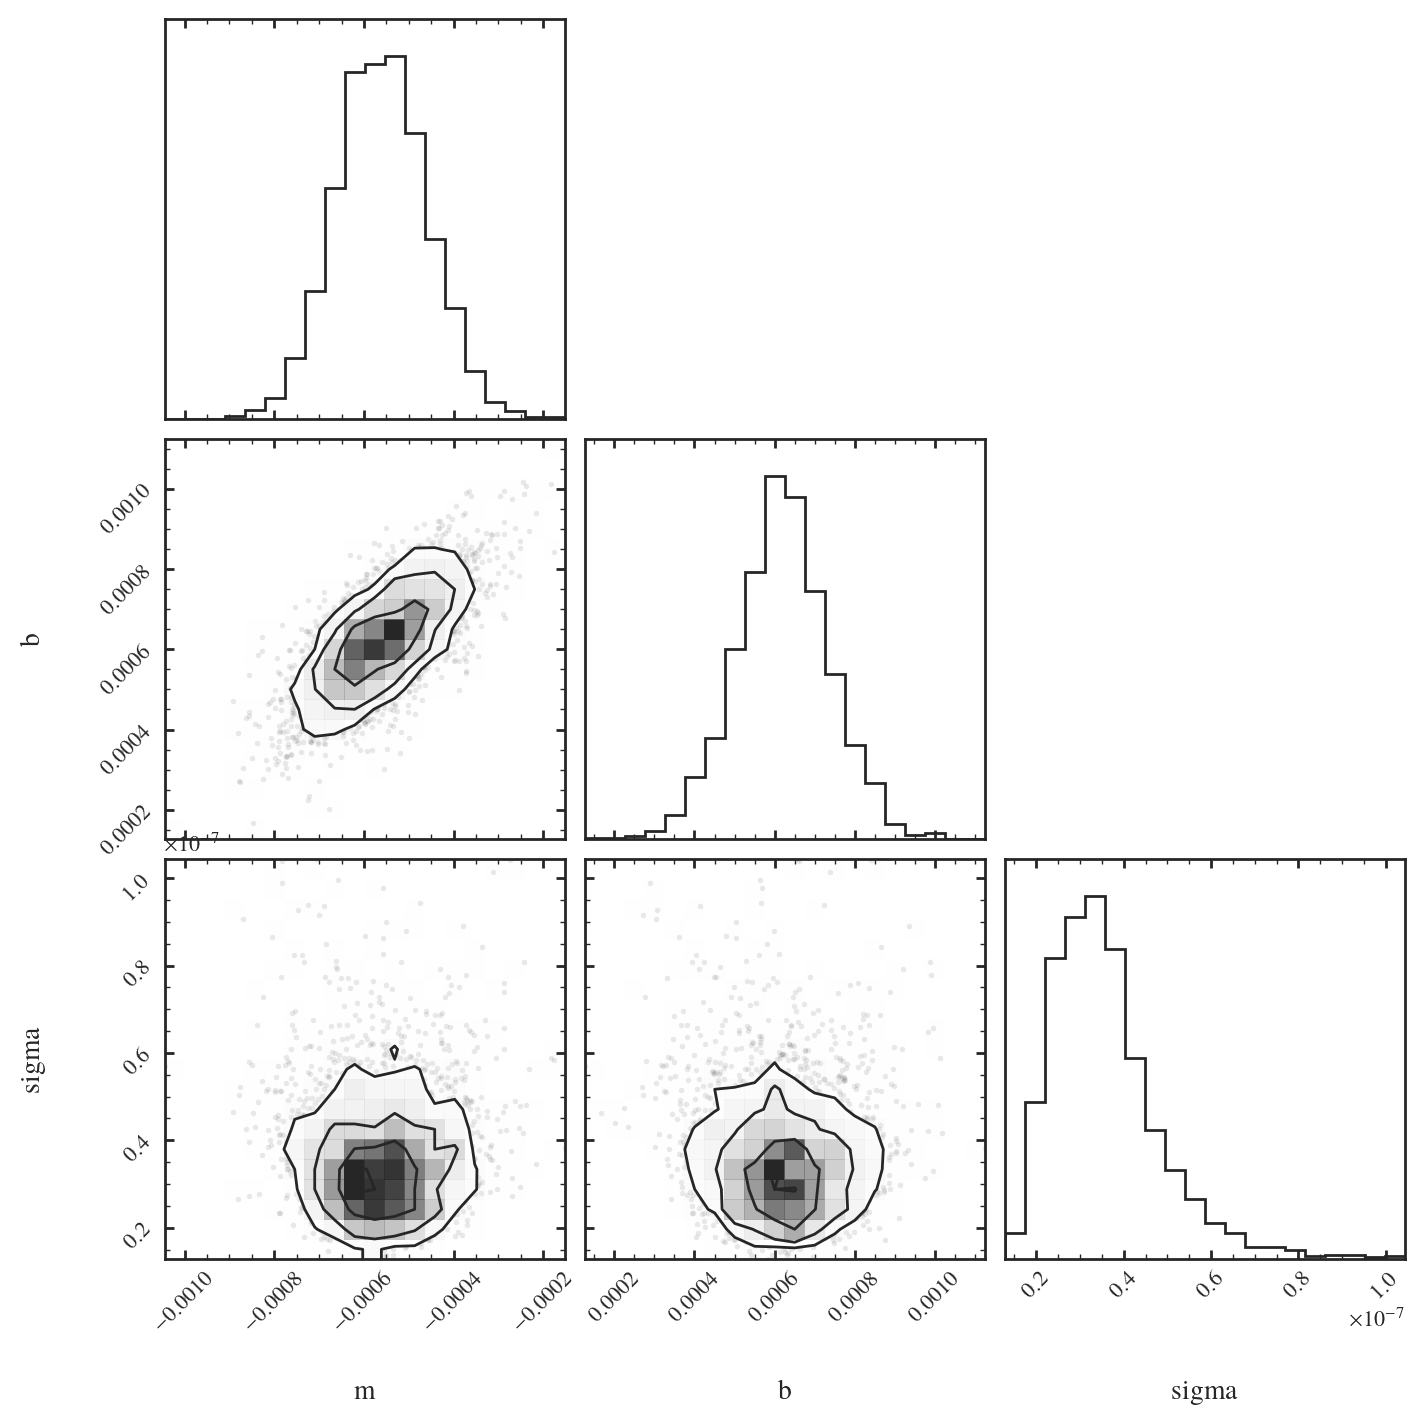

In [69]:

model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

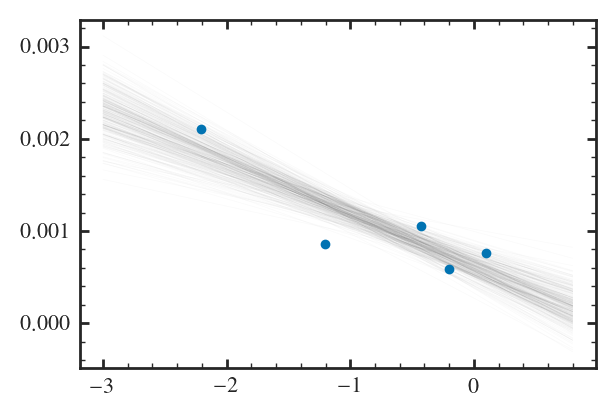

In [70]:
for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 0.8, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.02)
    
plt.scatter(mh1, y_c_agb1, zorder=3)


In [71]:
print_stats()

y(0) 0.000693482841654834
y0
6.208e-04  + 9.350e-05 - 9.532e-05
zeta
-1.525e-02  + 2.343e-03 - 2.282e-03
sigma
3.361e-08  + 1.046e-08 - 8.044e-09
